In [ ]:
#@title Setting up environment
from google.colab import output

!curl -s https://packagecloud.io/install/repositories/github/git-lfs/script.deb.sh | sudo bash
!sudo apt-get install git-lfs
!git lfs install
!git clone https://github.com/Quiexx/SpaceFace.git

!pip install click requests tqdm pyspng imageio-ffmpeg==0.4.3

!pip uninstall torchvision -y
!pip uninstall torch -y
!pip install torchvision==0.4.2
!pip install torch==1.7.1

!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!sudo unzip ninja-linux.zip -d /usr/local/bin/
!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force

%cd SpaceFace

output.clear()
print("Environment is set up")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#@title Imports

import pickle
import torch
import PIL
import numpy as np
import torchvision.transforms as transforms
import math
import os

def t2i(t):
  return PIL.Image.fromarray((t*127.5+127).clamp(0,255)[0].permute(1,2,0).cpu().numpy().astype('uint8'))

In [3]:
#@title Load network 
#@markdown Path from content/

model_path = "models/space_face.pkl" #@param {type:"string"}
model_path = os.path.abspath(model_path)

%cd stylegan2-ada-pytorch

with open(model_path, "rb") as f:
  model = pickle.load(f)

%cd ..

/content/SpaceFace/stylegan2-ada-pytorch
/content/SpaceFace


Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
Seed: 4626299924788034287


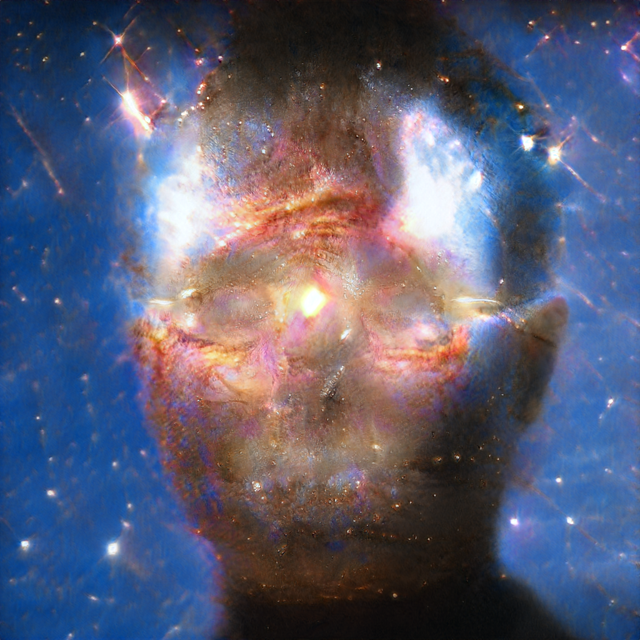

In [4]:
#@title Run model
#@markdown If seed is None, then torch.seed() is used

#@markdown Interesting seeds:

#@markdown 4626299924788034287


seed =  4626299924788034287#@param
if seed is None:
  seed = torch.seed()

torch.manual_seed(seed)

z = torch.randn([1, model.z_dim]).cuda() 
c = None 
w = model.mapping(z, c, truncation_psi=0.5, truncation_cutoff=8)
                           
img = model.synthesis(w, noise_mode='const', force_fp32=True)
print(f"Seed: {seed}")
display(t2i(img).resize((640, 640))) 

In [5]:
#@title Loading directions

eyes_open = torch.from_numpy(np.load('directions/eyes_open.npy').astype(np.float32)).cuda()
lip_ratio = torch.from_numpy(np.load('directions/lip_ratio.npy').astype(np.float32)).cuda()
pitch = torch.from_numpy(np.load('directions/pitch.npy').astype(np.float32)).cuda()
yaw = torch.from_numpy(np.load('directions/yaw.npy').astype(np.float32)).cuda()


In [6]:
#@title Loading psp

psp_path = "models/psp_ffhq_encode.pt"
psp_path = os.path.abspath(psp_path)

%cd pixel2style2pixel

from argparse import Namespace
from models.psp import pSp

ckpt = torch.load(psp_path, map_location='cpu')
opts = ckpt['opts']

opts['checkpoint_path'] = psp_path
if 'learn_in_w' not in opts:
    opts['learn_in_w'] = False
if 'output_size' not in opts:
    opts['output_size'] = 1024

opts = Namespace(**opts)
net = pSp(opts)
net.eval()
net.cuda()
print('Model successfully loaded!')

%cd ..

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])

def mix_with_directions(source: torch.Tensor, directions: torch.Tensor, weights: float) -> torch.Tensor:
    latent = source.clone()
    for d, w in zip(directions, weights):
        latent += d * w
    latent += net.latent_avg.repeat(latent.shape[0], 1, 1)
    return latent

/content/SpaceFace/pixel2style2pixel
Loading pSp from checkpoint: /content/SpaceFace/models/psp_ffhq_encode.pt
Model successfully loaded!
/content/SpaceFace


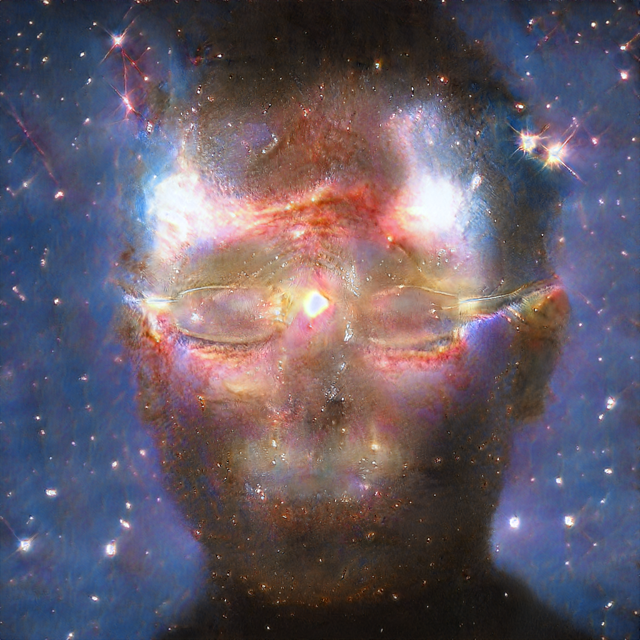

In [7]:
#@title Directions

w_eyes_open = 0 #@param {type:"slider", min:-10, max: 10, step:1}
w_lip_ratio = 1 #@param {type:"slider", min:-10, max: 10, step:1}
w_pitch = 0 #@param {type:"slider", min:-10, max: 10, step:1}
w_yaw = 0 #@param {type:"slider", min:-10, max: 10, step:1}

latent = mix_with_directions(w, [eyes_open, lip_ratio, pitch, yaw], [w_eyes_open, w_lip_ratio, w_pitch, w_yaw])

img = model.synthesis(latent, noise_mode='const', force_fp32=True)

img = t2i(img)
img.resize((640, 640))

In [ ]:
#@title Create custom animation

save_path = "../drive/MyDrive/animation.gif" #@param {type: "string"}

#@markdown ---
#@markdown Directions

#@markdown Open eyes:
open_eyes_from =  0#@param {type: "number"}
open_eyes_to =  0#@param {type: "number"}

#@markdown Lip ratio:
lip_ratio_from =  1#@param {type: "number"}
lip_ratio_to =  1#@param {type: "number"}

#@markdown Pitch:
pitch_from =  -10#@param {type: "number"}
pitch_to =  10#@param {type: "number"}

#@markdown Yaw:
yaw_from =  -10#@param {type: "number"}
yaw_to =  10#@param {type: "number"}

#@markdown ---

frame_count =  30#@param {"type": "integer"}
duration = 100 #@param {"type": "integer"}
loop = True #@param {"type": "boolean"}


frames = []

open_eyes_step = (open_eyes_to - open_eyes_from) / frame_count
lip_ratio_step = (lip_ratio_to - lip_ratio_from) / frame_count
pitch_step = (pitch_to - pitch_from) / frame_count
yaw_step = (yaw_to - yaw_from) / frame_count


for frame_number in range(frame_count):
  w_eyes_open = open_eyes_from + frame_number * open_eyes_step
  w_lip_ratio = lip_ratio_from + frame_number * lip_ratio_step
  w_pitch = pitch_from + frame_number * pitch_step
  w_yaw = yaw_from + frame_number * yaw_step

  latent = mix_with_directions(w, [eyes_open, lip_ratio, pitch, yaw], [w_eyes_open, w_lip_ratio, w_pitch, w_yaw])

  img = model.synthesis(latent, noise_mode='const', force_fp32=True)
  img = t2i(img)

  frames.append(img)

if loop:
  frames.extend(frames[::-1])

frames[0].save(
    save_path,
    save_all=True,
    append_images=frames[1:], 
    optimize=True,
    duration=duration,
    loop=0
)

print("Gif created!")

Gif created!


In [ ]:
#@title Use prepared animations
#@markdown 1: looped horizontal rotation

#@markdown 2: looped horizontal and vertical rotation

#@markdown 3: rotation in a square

#@markdown 4: rotation in a circle


anim_type = "4" #@param [1, 2, 3, 4]
save_path = "../drive/MyDrive/animation.gif" #@param {type: "string"}
frame_count =  30#@param {"type": "integer"}
duration = 100 #@param {"type": "integer"}

def h_rotation():
  frames = []
  yaw_from =  -10
  yaw_to =  10
  yaw_step = (yaw_to - yaw_from) / frame_count

  for frame_number in range(frame_count):
    w_yaw = yaw_from + frame_number * yaw_step

    latent = mix_with_directions(w, [yaw], [w_yaw])

    img = model.synthesis(latent, noise_mode='const', force_fp32=True)
    img = t2i(img)

    frames.append(img)


  frames.extend(frames[::-1])

  frames[0].save(
      save_path,
      save_all=True,
      append_images=frames[1:], 
      optimize=True,
      duration=duration,
      loop=0
  )

  print("Gif created!")

def h_v_rotation():
  pitch_from = -10
  pitch_to = 10

  yaw_from = -10
  yaw_to = 10
  yaw_step = (yaw_to - yaw_from) / frame_count
  pitch_step = (pitch_to - pitch_from) / frame_count
  
  frames = []

  for frame_number in range(frame_count):
    w_yaw = yaw_from + frame_number * yaw_step
    w_pitch = pitch_from + frame_number * pitch_step

    latent = mix_with_directions(w, [pitch, yaw], [w_pitch, w_yaw])

    img = model.synthesis(latent, noise_mode='const', force_fp32=True)
    img = t2i(img)

    frames.append(img)


  frames.extend(frames[::-1])

  frames[0].save(
      save_path,
      save_all=True,
      append_images=frames[1:],  
      optimize=True,
      duration=duration,
      loop=0
  )

  print("Gif created!")

def square_rotation():
  fc_stage = frame_count // 4

  frames = []

  # 1 stage
  pitch_from, pitch_to = -10, 10
  pitch_step = (pitch_to - pitch_from) / fc_stage

  w_yaw = -10

  for frame_number in range(fc_stage):
    w_pitch = pitch_from + frame_number * pitch_step

    latent = mix_with_directions(w, [pitch, yaw], [w_pitch, w_yaw])

    img = model.synthesis(latent, noise_mode='const', force_fp32=True)
    img = t2i(img)

    frames.append(img)

  # 2 stage
  w_pitch = 10
  yaw_from, yaw_to = -10, 10
  yaw_step = (yaw_to - yaw_from) / fc_stage

  for frame_number in range(fc_stage):
    w_yaw = yaw_from + frame_number * yaw_step

    latent = mix_with_directions(w, [pitch, yaw], [w_pitch, w_yaw])

    img = model.synthesis(latent, noise_mode='const', force_fp32=True)
    img = t2i(img)

    frames.append(img)

  # 3 stage
  pitch_from, pitch_to = 10, -10
  pitch_step = (pitch_to - pitch_from) / fc_stage

  w_yaw = 10

  for frame_number in range(fc_stage):
    w_pitch = pitch_from + frame_number * pitch_step

    latent = mix_with_directions(w, [pitch, yaw], [w_pitch, w_yaw])

    img = model.synthesis(latent, noise_mode='const', force_fp32=True)
    img = t2i(img)

    frames.append(img)

  # 4 stage
  w_pitch = -10
  yaw_from, yaw_to = 10, -10
  yaw_step = (yaw_to - yaw_from) / fc_stage

  for frame_number in range(fc_stage):
    w_yaw = yaw_from + frame_number * yaw_step

    latent = mix_with_directions(w, [pitch, yaw], [w_pitch, w_yaw])

    img = model.synthesis(latent, noise_mode='const', force_fp32=True)
    img = t2i(img)

    frames.append(img)

  frames[0].save(
      save_path,
      save_all=True,
      append_images=frames[1:],  
      optimize=True,
      duration=duration,
      loop=0
  )

  print("Gif created!")

def circle_rotation():
  fc_stage = frame_count // 4

  frames = []

  # 1 stage
  pitch_from, pitch_to = -10, 0
  pitch_step = (pitch_to - pitch_from) / fc_stage

  yaw_from, yaw_to = 0, -10
  yaw_step = (yaw_to - yaw_from) / fc_stage


  for frame_number in range(fc_stage):
    w_pitch = pitch_from + frame_number * pitch_step
    w_yaw = yaw_from + frame_number * yaw_step

    latent = mix_with_directions(w, [pitch, yaw], [w_pitch, w_yaw])

    img = model.synthesis(latent, noise_mode='const', force_fp32=True)
    img = t2i(img)

    frames.append(img)

  # 2 stage
  pitch_from, pitch_to = 0, 10
  pitch_step = (pitch_to - pitch_from) / fc_stage
  
  yaw_from, yaw_to = -10, 0
  yaw_step = (yaw_to - yaw_from) / fc_stage

  for frame_number in range(fc_stage):
    w_pitch = pitch_from + frame_number * pitch_step
    w_yaw = yaw_from + frame_number * yaw_step

    latent = mix_with_directions(w, [pitch, yaw], [w_pitch, w_yaw])

    img = model.synthesis(latent, noise_mode='const', force_fp32=True)
    img = t2i(img)

    frames.append(img)

  # 3 stage
  pitch_from, pitch_to = 10, 0
  pitch_step = (pitch_to - pitch_from) / fc_stage
  
  yaw_from, yaw_to = 0, 10
  yaw_step = (yaw_to - yaw_from) / fc_stage

  for frame_number in range(fc_stage):
    w_pitch = pitch_from + frame_number * pitch_step
    w_yaw = yaw_from + frame_number * yaw_step

    latent = mix_with_directions(w, [pitch, yaw], [w_pitch, w_yaw])

    img = model.synthesis(latent, noise_mode='const', force_fp32=True)
    img = t2i(img)

    frames.append(img)

  # 4 stage
  pitch_from, pitch_to = 0, -10
  pitch_step = (pitch_to - pitch_from) / fc_stage
  
  yaw_from, yaw_to = 10, 0
  yaw_step = (yaw_to - yaw_from) / fc_stage

  for frame_number in range(fc_stage):
    w_pitch = pitch_from + frame_number * pitch_step
    w_yaw = yaw_from + frame_number * yaw_step

    latent = mix_with_directions(w, [pitch, yaw], [w_pitch, w_yaw])

    img = model.synthesis(latent, noise_mode='const', force_fp32=True)
    img = t2i(img)

    frames.append(img)

  frames[0].save(
      save_path,
      save_all=True,
      append_images=frames[1:],  
      optimize=True,
      duration=duration,
      loop=0
  )

  print("Gif created!")


anims = {"1": h_rotation, "2": h_v_rotation, "3": square_rotation, "4": circle_rotation}
anims[anim_type]()

Gif created!
